## Chapter 11 : Attention Mechanisms and Transformers
- **Idea** : attention first come up in encoder - decoder design, rather than tranform the input to a fixed size feature and the feed it to all the decoder step, we want to create a representation that has the same length of input and decoder at each time step can pay attention to different input sequence (with it's weight). And transfromer give up residual connection, instead use attention at all.
- **Q, K, V**
  - Define database $\mathcal{D} \stackrel{\mathrm{d e f}} {=} \{( \mathbf{k}_{1}, \mathbf{v}_{1} ), \ldots( \mathbf{k}_{m}, \mathbf{v}_{m} ) \} $, give some query, the attention is $\text{Attention}(q, D) \stackrel{\mathrm{d e f}} {=} \sum_{i=1}^m \alpha(q, k_i)v_i $, where $\alpha(q, k_i)$ are scalar attention weight, this operation is also called attention pooling. We want this attention weight to be larger than 0 and sum up to 1, so we can use a softmax to transfrom it.
- **Attention pooling with similarity**
  - In a regression task, we can use kernel output as the attention weight (after normalization).
  - When directly compute loss $(f(x_i) - y_i)^2$， because we have $y_i$, the $\sigma$ will go to zero, causing overfitting. Even if we remove $y_i$ from the loss, if the dataset is large enough, we may still overfit.
  - <img alt="Attention Pooling" src="https://d2l.ai/_images/attention-output.svg" style="background-color: white; display: inline-block;"> Attention Pooling
- **Attention Scoring Function**
  - **Dot Product Attention**: note that kernel of gaussian is $a(q, k_i) = q^{\intercal}k_i - 0.5 * ||q||^2 - 0.5 * ||k_i||^2$, and after the softmax normalization, second one is cancled out. Then if we get $k_i$ with batch or layer normalization, it's length will be bounded and often constant, so we can get rid of last term without penalty. This leads to $a(q, k_i) = q^{\intercal}k_i$, ann assume both $q$ and $k_i$ have zero mean and unit variance, this attention weight will have a variance of $d$ (which is query feature size), so we can further normalize it : $a(q, k_i) = q^{\intercal}k_i / \sqrt{d}$, this is the common one used in transformer. At last, we do a softmax on it.
  - Because we do not want consider \<pad\>, so we can do musk softmax. And for Batch Matrix Multiplication, use torch.bmm. bmm(Q, K) take Q(n, a, b) and K(n, b, c), which return [Q1 @ K1, ..., Q_n @ K_n].
  - **Additive Attention**: when q and k has different feature size, we can do a transform ($q^{\intercal}Mk$), or use this additive attention $a(\mathbf{q},\mathbf{k})=\mathbf{w}_v^\top\tanh(\mathbf{W}_q\mathbf{q}+\mathbf{W}_k\mathbf{k})\in\mathbb{R}$, inside the () we add by broadcasting.
- **Bahdanau Attention**
  - Attention function will work between encoder hidden state and decoder hidden state, $c_{t'} = \sum_t^T a(s_{t'-1}, h_t)h_t$, and this will used to generate $s_{t'}$.
  - <img alt="Bahdanau Attention" src="https://d2l.ai/_images/seq2seq-details-attention.svg" style="background-color: white; display: inline-block;"> Bahdanau Attention
  - Seq2SeqAttentionDecoder first use encoder last layer hidden state as the query, and later use it's own hidden state from it's rnn model. Keys and values are all encoder outputs (last layer hidden state at all time step), then concatenate the embed X with this context (attention result) then feed to it's rnn.
- **Multi-head Attention**
  - <img alt="Multi-head Attention" src="https://d2l.ai/_images/multi-head-attention.svg" style="background-color: white; display: inline-block;"> Multi-head Attention
  - We want the same Q, K, V to have different behaviour with the same attention mechanism, so we have to copy them $h$ times and first pass them into FC layer which has learnable param that can change the QKV, then feed to attention, get $h$ results, concatenate them. $h_i = f(W_i^{q}q_i, W_i^kk_i, W_i^vv_i)$, $f$ is attention pooling, each $W$ have shape of $(p_q, d_q), (p_k, d_k)$ and $(p_v, d_v)$, $h_i$ is of shape $(p_v,)$. We concatenate these h to a $(h \times p_v,)$ shape. And we use a big learnable matrix of shape $(p_o, h \times p_v)$ times the concatenated result, which finnally return output of shape $(p_o, )$. For the purpose of parallel computation, we set $hp_q = hp_k = hp_v = p_o$.
  - Impl of d2l is the same idea, but for parrallel, it use some trick, hidden_size is h * p_q, put num_head into batch_size, make the batch_size = batch_size * num_head, and in the output reverse it.
- **Self Attention**
  - Do the attention(X, X, X) to get encoder. Compare CNN, RNN and self-attention, given n sequence with d dimension. CNN : choose kernel of 3, computation is O(knd^2), longest connect path is O(n/k). RNN : compute O(nd^2), path O(n). Self attention : compute O(n^2d), path O(1).
  - Positional Encoding: self attention does not contain position (order) information, so a token at time step 1 and 5 are the same (but it should not!). So we need to add something to keep the position information. First we use fixed position encoding with sine and cosine. $X^{n \times d}$ is the input representation of n tokens, and the position encoding is $X + P$, where $p_{i,2j} = \sin \left( \frac{i}{10000^{2j/d}} \right)$ and $p_{i,2j+1} = \cos \left( \frac{i}{10000^{2j/d}} \right)$. This works because the function abouve contain different frequency information.
  - Relative position encoding : $\begin{bmatrix}
\cos(\delta\omega_j) & \sin(\delta\omega_j) \\
-\sin(\delta\omega_j) & \cos(\delta\omega_j)
\end{bmatrix}
\begin{bmatrix}
p_{i,2j} \\
p_{i,2j+1}
\end{bmatrix} = \begin{bmatrix}
p_{i+\delta,2j} \\
p_{i+\delta,2j+1}
\end{bmatrix}$, we can just add a (1, step, hidden) param, and add it to the embed(X) to learn the position.
- **Transformer**
  - <img alt="Transformer" src="https://d2l.ai/_images/transformer.svg" style="background-color: white; display: inline-block;"> Transformer Arch
  - The encoder-decoder attention layer take decoder self-attention layer output as query, and encoder output as key and value.
  - Note that in decoder self-attention, we will carefully mask output to reserve the autoregreesive nature, we do not take position in the outpt (later as the input of decoder self-attention layer) after the position we are calculating.
  - Before pos encoding we first multiply sqrt(d) with embed(X) to rescale it, maybe because embed(X) has small variace.
  - For prediction, we need to cache the input X for the decoder, in training we can just compute all time step all together. In impl, it is cached in state[2].
  - **!!** only the last output of the encoder will do attention on all block of decoder.
- **Vision Transformer**
  - <img alt="Vision Transformer" src="https://d2l.ai/_images/vit.svg" style="background-color: white; display: inline-block;"> Vision Transformer
  - patch embeding will feed to a conv then flatten it, return shape of (batch, patch, hidden)
  - Do the normalization before the attention is better for the efficient learning of transformer. The vit mlp layer use GELU and dropout is applied to the output of each fully connected layer in the MLP for regularization.

- Large Scale Pre-training
  - Encoder only, ViT, BERT. BERT use masked language modeling, and for a token, tokens at left and right can all attend to this masked token. So it is a bidirection encoder --- in the figure below, each token along the vertical axis attends to all input tokens along the horizontal axis.
  - <img alt="BERT" src="https://d2l.ai/_images/bert-encoder-only.svg" style="background-color: white; display: inline-block;"> BERT
  - Encoder-Decoder, BART & T5, both attempt to reconstruct original text in their pretraining objectives, while the former emphasizes noising input (e.g., masking, deletion, permutation, and rotation) and the latter highlights multitask unification with comprehensive ablation studies.
  - <img alt="T5" src="https://d2l.ai/_images/t5-encoder-decoder.svg" style="background-color: white; display: inline-block;"> T5
  - Decoder only, GPT. **In-context learning** : conditional on an input sequence with the task description, task-specific input–output examples, and a prompt (task input). 
  - <img alt="GPT" src="https://d2l.ai/_images/gpt-decoder-only.svg" style="background-color: white; display: inline-block;"> GPT
  - <img alt="x - shot" src="https://d2l.ai/_images/gpt-3-xshot.svg" style="background-color: white; display: inline-block;"> x-shot
- Efficient Transformer design (see that survey)
  - Sparse attention：Longformer：使用滑动窗口和全局注意力，降低复杂度到O(n)。BigBird：结合随机注意力、窗口注意力和全局注意力，适合长序列。
  - Low rank approximation：Linformer：通过低秩分解将注意力矩阵投影到较低维度，复杂度从O(n²)降到O(n)。
  - Memory：Transformer-XL：引入循环记忆，处理长序列时重用之前的隐藏状态，避免重复计算。
  - Efficient attention：Performer：使用核方法（Favor+）近似点积注意力，复杂度降为O(n)。
  - Model compress：Distillation：将大Transformer蒸馏为小模型（如DistilBERT）。量化：减少参数精度，降低内存占用。
<!-- <img alt="ResNeXt Block" src="https://d2l.ai/_images/rnn.svg" style="background-color: white; display: inline-block;"> -->
<!-- <img alt="ResNeXt Block" src="https://d2l.ai/_images/rnn-bptt.svg" style="background-color: white; display: inline-block;"> -->

In [1]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from torchinfo import summary
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

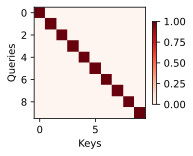

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

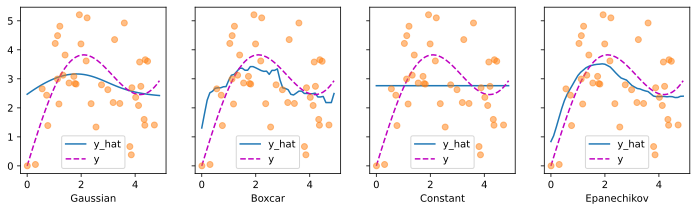

In [4]:
def f(x):
    return 2 * torch.sin(x) + x

def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train @ attention_w
    return y_hat, attention_w

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')

def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)
        
n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

plot(x_train, y_train, x_val, y_val, kernels, names)

In [7]:
dist = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
k = gaussian(dist)
attention_w = k / k.sum(0)
print(dist.shape, k.shape, k.sum(0).shape, y_train.shape, attention_w.shape)
print(dist[0][:5], x_train[0], x_val[:5]) 

torch.Size([40, 50]) torch.Size([40, 50]) torch.Size([50]) torch.Size([40]) torch.Size([40, 50])
tensor([ 0.0049, -0.0951, -0.1951, -0.2951, -0.3951]) tensor(0.0049) tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000])


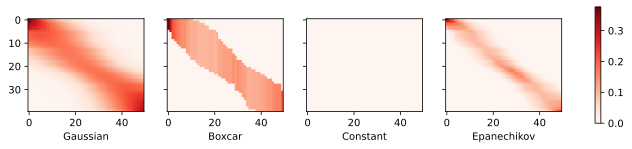

In [8]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

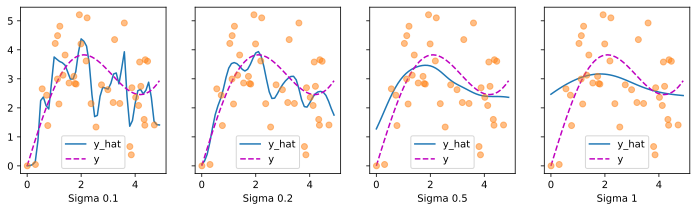

In [9]:
'''
With different lengthscale of gaussian kernel
'''
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

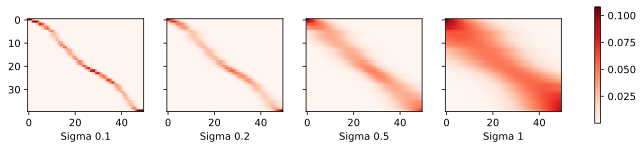

In [10]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

In [2]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        # print(X.shape, valid_len.shape, mask.shape, valid_len[:, None].shape)
        # torch.Size([4, 4]) torch.Size([4]) torch.Size([4, 4]) torch.Size([4, 1])
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [17]:
ms = masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))
print(ms.shape)
print(ms)

torch.Size([4, 4]) torch.Size([4]) torch.Size([4, 4]) torch.Size([4, 1])
torch.Size([2, 2, 4])
tensor([[[0.6440, 0.3560, 0.0000, 0.0000],
         [0.6039, 0.3961, 0.0000, 0.0000]],

        [[0.2836, 0.4011, 0.3153, 0.0000],
         [0.2704, 0.4749, 0.2547, 0.0000]]])


In [19]:
test = torch.arange((2), dtype=torch.float32,)
print(test.shape)
print(test[None, :].shape)

torch.Size([2])
torch.Size([1, 2])


In [20]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

torch.Size([4, 4]) torch.Size([4]) torch.Size([4, 4]) torch.Size([4, 1])


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3807, 0.2688, 0.3504, 0.0000]],

        [[0.3575, 0.6425, 0.0000, 0.0000],
         [0.2223, 0.1623, 0.2987, 0.3167]]])

In [21]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
torch.bmm(Q, K).shape

torch.Size([2, 3, 6])

In [3]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [31]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
output = attention(queries, keys, values, valid_lens)
print(output.shape)

torch.Size([2, 10]) torch.Size([2]) torch.Size([2, 10]) torch.Size([2, 1])
torch.Size([2, 1, 4])


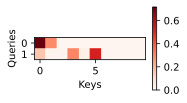

In [26]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [4]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features) # feature size is (batch_size, n.queries, n.keys, num_hiddens)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        # print(queries.shape, keys.shape, features.shape, scores.shape)
        # torch.Size([2, 1, 8]) torch.Size([2, 10, 8]) torch.Size([2, 1, 10, 8]) torch.Size([2, 1, 10])
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [42]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
ad = attention(queries, keys, values, valid_lens)
print(ad.shape)

torch.Size([2, 1, 8]) torch.Size([2, 10, 8]) torch.Size([2, 1, 10, 8]) torch.Size([2, 1, 10])
torch.Size([2, 10]) torch.Size([2]) torch.Size([2, 10]) torch.Size([2, 1])
torch.Size([2, 1, 4])


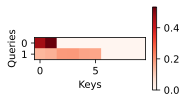

In [35]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [40]:
print(torch.normal(0, 1, (2, 1, 20)).unsqueeze(2).shape)
print(torch.normal(0, 1, (2, 1, 10, 1)).squeeze(-1).shape)

torch.Size([2, 1, 1, 20])
torch.Size([2, 1, 10])


In [5]:
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Encoder(nn.Module):  #@save
    """The base encoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError
        
class Seq2SeqEncoder(Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout = dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state
        
class Decoder(nn.Module):  #@save
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError
        
class AttentionDecoder(Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

class Classifier(nn.Module):
    """The base class of classification models.

    Defined in :numref:`sec_classification`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.
    
        Defined in :numref:`sec_classification`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
        compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
        return d2l.reduce_mean(compare) if averaged else compare

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def layer_summary(self, X_shape):
        """Defined in :numref:`sec_lenet`"""
        X = d2l.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
            
class EncoderDecoder(Classifier):  #@save
    """The base class for the encoder--decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

    def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state) # output is a list!
            outputs.append(Y.argmax(2)) # Y is (batch, 1(step), vocab), so ouput is (batch, 1)
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights # do not return <pad>, and return (batch, step)
        
class Seq2Seq(EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_pad = tgt_pad
        self.lr = lr

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super().loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

In [14]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
print(output.shape)
print(state[0].shape)
print(state[1][0].shape)

torch.Size([4, 7, 10])
torch.Size([4, 7, 16])
torch.Size([4, 16])


In [6]:
class MultiHeadAttention(nn.Module):  #@save
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # Shape of input X: (batch_size, no. of queries or key-value pairs,
        # num_hiddens). Shape of output X: (batch_size, no. of queries or
        # key-value pairs, num_heads, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        # Shape of output X: (batch_size, num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        X = X.permute(0, 2, 1, 3)
        # Shape of output: (batch_size * num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])

    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)
        
    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [17]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
ans = attention(X, Y, Y, valid_lens)
print(ans.shape)

torch.Size([2, 4, 100])


In [22]:
'''
Self - Attention
'''
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
X = torch.ones((batch_size, num_queries, num_hiddens))
print(X.shape)

torch.Size([2, 4, 100])


In [7]:
'''
Fixed Position Encoding
'''
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [17]:
Xp = torch.ones((2, 2, 4))
position = PositionalEncoding(4, 0.5)
position.eval()
res1 = position(Xp)
res2 = position(Xp * math.sqrt(Xp.shape[-1]))
print(res1)
print(res2)

tensor([[[1.0000, 2.0000, 1.0000, 2.0000],
         [1.8415, 1.5403, 1.0100, 1.9999]],

        [[1.0000, 2.0000, 1.0000, 2.0000],
         [1.8415, 1.5403, 1.0100, 1.9999]]])
tensor([[[2.0000, 3.0000, 2.0000, 3.0000],
         [2.8415, 2.5403, 2.0100, 2.9999]],

        [[2.0000, 3.0000, 2.0000, 3.0000],
         [2.8415, 2.5403, 2.0100, 2.9999]]])


In [21]:
'''
Transformer Architecture
'''
class PositionWiseFFN(nn.Module):  # (batch, step or sequence length, hidden or dimension) -> (*, *, ffn)
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

class TransformerEncoderBlock(nn.Module):  #@save
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

class TransformerEncoder(Encoder):  #@save
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else: # JBL: for the prediction auto regressive nature
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


In [11]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
print(encoder_blk(X, valid_lens).shape)

torch.Size([2, 100, 24])


In [20]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
print(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape)

torch.Size([2, 100, 24])


In [23]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
res = decoder_blk(X, state)
print(res[0].shape)

torch.Size([2, 100, 24])


In [30]:
'''
Vision Transformer
'''
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))

class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

class ViT(Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])


In [27]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)
print(patch_emb(X).shape) # batch, (img_size / patch)^2, hidden 

torch.Size([4, 36, 512])


In [32]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
print(encoder_blk(X).shape)

torch.Size([2, 100, 24])


In [28]:
!nvidia-smi

Mon Apr  7 15:08:53 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   40C    P8              52W / 115W |   2444MiB /  8188MiB |     21%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--